In [1]:
# Load my Packages
import requests
import json
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [2]:
# Assign hidden API key
with open("api_stuff.txt", "r") as file:
    api_key = file.read()

In [3]:
# Tables that are ready
players_df = pd.read_csv('data/players.csv')
ts_df = pd.read_csv('data/teams.csv')
stats = pd.read_csv('data/stats.csv')
final_df = pd.read_csv('data/final_table.csv')

In [8]:
final_df.shape

(30, 32)

In [6]:
# Extract Teams info from API
urlt = "https://api-nba-v1.p.rapidapi.com/teams"

headers = {
	"X-RapidAPI-Key": api_key,
	"X-RapidAPI-Host": "api-nba-v1.p.rapidapi.com"
}

teams = requests.get(urlt, headers=headers)
t_df = pd.DataFrame(teams.json()['response'])

# Select only the ones in the nba Franchise
t_df = t_df[t_df['nbaFranchise'] == True]

#Clippers id = 16
#t_df.to_csv('teams.csv', index=False)


In [15]:
# Get players info from API
urlp = "https://api-nba-v1.p.rapidapi.com/players"

# Create empty dataframe
columns = ['id', 'firstname', 'lastname', 'birth', 'nba', 'height', 'weight', 'college', 'affiliation', 'leagues']
players_df = pd.DataFrame(columns=columns)
teams = []
team_ids = []

# For each team
querystring = {"team": '16', "season": "2023"}

headers = {
	"X-RapidAPI-Key": api_key,
	"X-RapidAPI-Host": "api-nba-v1.p.rapidapi.com"
}

players = requests.get(urlp, headers=headers, params=querystring)

p_df = pd.DataFrame(players.json()['response'])


In [23]:
# Clean Players Data

# Add Birth date column
p_df['birth_date'] = p_df['birth'].apply(lambda x: pd.to_datetime(x['date']) if x['date'] else None)

# Add height in meters column
p_df['height_m'] = p_df['height'].apply(lambda x: float(x['meters']) if x['meters'] else None)

# Add weight in kilograms column
p_df['weight_kg'] = p_df['weight'].apply(lambda x: float(x['kilograms']) if x['kilograms'] else None)

# Remove unnecessary columns
p_df = p_df[['id', 'firstname', 'lastname', 'birth_date', 'height_m', 'weight_kg']]

# Remove players with NAs
p_df = p_df.dropna()

# Create Age column
p_df['age'] = (datetime.now() - p_df['birth_date']).astype('<m8[Y]').astype(int)

In [25]:
# add each player info season and team to my players df
players_df = pd.concat([players_df, p_df], ignore_index=True)

# Order by Player ID
players_df = players_df.sort_values('id')

In [36]:
# Write into a csv File
# players_df.to_csv('players.csv', index=False)

In [95]:
# Get Player stats per game info from API
urlps = "https://api-nba-v1.p.rapidapi.com/players/statistics"
ps = pd.DataFrame()
for i in range(30,40): # I have 144 players so far 
	querystring = {"id":players_df.iloc[i]['id'],"season":"2023"}

	headers = {
		"X-RapidAPI-Key": api_key,
		"X-RapidAPI-Host": "api-nba-v1.p.rapidapi.com"
	}

	player_ps = requests.get(urlps, headers=headers, params=querystring)
	ps = pd.concat([ps, pd.DataFrame(player_ps.json()['response'])], ignore_index=True)


In [97]:
# Clean stats table

# Add player id
ps['id'] = ps['player'].apply(lambda x: x['id'] if x['id'] else None)

# Add player name
ps['name'] = ps['player'].apply(lambda x: x['firstname'] + " "  + x['lastname'])

# Add team code
ps['team'] = ps['team'].apply(lambda x: x['code'] if x['code'] else None)

# Edit plusMinus to be a number
ps['plusMinus'] = ps['plusMinus'].apply(lambda x: int(x[1:]) * -1 if x and x[0] == '-' else int(x) if x != '' else None)

# Edit min to be a number
ps['min'] = ps['min'].astype(int)

# Make them numeric otherwise null for percentage columns
ps['fgp'] = pd.to_numeric(ps['fgp'], errors='coerce')
ps['ftp'] = pd.to_numeric(ps['ftp'], errors='coerce')
ps['tpp'] = pd.to_numeric(ps['tpp'], errors='coerce')

#ps

,player,team,game,points,pos,min,fgm,fga,fgp,ftm,...,totReb,assists,pFouls,steals,turnovers,blocks,plusMinus,comment,id,name
0,"{'id': 286, 'firstname': 'DeAndre', 'lastname'...",DEN,{'id': 12496},4,C,9,2,3,66.7,0,...,1,4,1,1,1,0,-4,None,286,DeAndre Jordan
1,"{'id': 286, 'firstname': 'DeAndre', 'lastname'...",DEN,{'id': 12505},0,C,9,0,0,0.0,0,...,2,2,1,0,0,0,-10,None,286,DeAndre Jordan
2,"{'id': 286, 'firstname': 'DeAndre', 'lastname'...",DEN,{'id': 12530},8,C,21,4,5,80.0,0,...,9,4,3,2,5,0,-17,None,286,DeAndre Jordan
3,"{'id': 286, 'firstname': 'DeAndre', 'lastname'...",DEN,{'id': 12634},1,C,12,0,0,0.0,1,...,1,1,2,0,1,0,-10,None,286,DeAndre Jordan
4,"{'id': 286, 'firstname': 'DeAndre', 'lastname'...",DEN,{'id': 12792},6,C,12,3,3,100.0,0,...,6,1,3,0,1,0,2,None,286,DeAndre Jordan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,"{'id': 365, 'firstname': 'Patty', 'lastname': ...",ATL,{'id': 12781},3,PG,5,1,2,50.0,0,...,1,0,0,0,0,0,-2,None,365,Patty Mills
126,"{'id': 374, 'firstname': 'Markieff', 'lastname...",DAL,{'id': 12545},4,PF,7,1,4,25.0,1,...,0,0,0,0,0,0,-3,None,374,Markieff Morris
127,"{'id': 374, 'firstname': 'Markieff', 'lastname...",DAL,{'id': 12687},0,PF,4,0,2,0.0,0,...,1,0,0,0,0,0,-8,None,374,Markieff Morris
128,"{'id': 374, 'firstname': 'Markieff', 'lastname...",DAL,{'id': 12737},2,PF,5,1,4,25.0,0,...,0,1,0,0,0,0,5,None,374,Markieff Morris


In [99]:
# Group by player
ps = ps.groupby('id').agg({
    'name': 'first',
    'team': 'first',
    'pos': 'first',
    'game': 'count',
    'points': 'mean',
    'min' : 'mean', 
    'fgm' : 'mean', 
    'fga': 'mean', 
    'fgp': 'mean',
    'ftm' : 'mean', 
    'fta': 'mean', 
    'ftp': 'mean', 
    'tpm': 'mean', 
    'tpa': 'mean', 
    'tpp': 'mean', 
    'offReb': 'mean', 
    'defReb': 'mean', 
    'totReb': 'mean',
    'assists': 'mean', 
    'pFouls': 'mean', 
    'steals': 'mean', 
    'turnovers': 'mean', 
    'blocks': 'mean',
    'plusMinus': 'mean'
}).reset_index().round()

# Make all numeric variables integers
ps.iloc[:, 4:] = ps.iloc[:, 4:].astype(int)

# Add performance column
ps['performnce'] = pd.cut(ps['plusMinus'], bins=[-float('inf'), -3, 3, float('inf')], labels=['low', 'average', 'high'])

# Add ball handling column
ps['ball_handling'] = np.round(1 - MinMaxScaler().fit_transform(ps['turnovers'].values.reshape(-1, 1)), 2)

# Turn percentages to decimals
ps['fgp'] = ps['fgp'] / 100
ps['ftp'] = ps['ftp'] / 100
ps['tpp'] = ps['tpp'] / 100

# Start over
# stats = pd.DataFrame()

# Add to our existing table
stats = pd.concat([stats, ps], ignore_index=True)

/var/folders/3g/j5vh3c7n53sb924vl6sb5jbc0000gn/T/ipykernel_5941/1000620652.py:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ps.iloc[:, 4:] = ps.iloc[:, 4:].astype(int)


In [107]:
# Write the table in a CSV file
# stats.to_csv('stats.csv', index=False)

In [64]:
# Create a t score formula 
def get_t(x, column):
    t = (x - column.mean()) / column.std()
    return t


In [71]:
# Create function to get greatest strength for a given player (row)
def get_b_strength(player):
    skills = ['fgp', 'ftp', 'tpp', 'totReb', 'assists', 'steals']
    max = -3
    m_skill = "None"
    for i in skills:
        t_score = get_t(player[i], stats[i])
        if t_score > max:
            max = t_score
            m_skill = i
    if max <= 0:
        if player['ball_handling'] >= .5:
            m_skill == 'ball_handling'
        elif player['blocks'] == 1:
            m_skill == 'ball_handling'
    return m_skill
    

In [74]:
# Create function to get worst weekednes for a given player (row)
def get_b_weakedness(player):
    w = ['turnovers', 'pFouls']
    max = -3
    m_skill = "None"
    for i in w:
        t_score = get_t(player[i], stats[i])
        if t_score > max:
            max= t_score
            m_skill = i
    if max <= 0:
        min = 3
        skills = ['fgp', 'ftp', 'tpp', 'totReb', 'assists', 'steals']
        for i in skills:
            t_score = get_t(player[i], stats[i])
            if t_score < min:
                min = t_score
                m_skill = i
        if min >= 0:
            if player['ball_handling'] <= .5:
                m_skill == 'ball_handling'
            elif player['blocks'] != 1:
                m_skill == 'ball_handling'
    return m_skill

In [108]:
# Create b_strength column
stats['b_strength'] = [get_b_strength(stats.iloc[i]) for i in range(len(stats))]

In [109]:
# Create b_weakedness column
stats['b_weakedness'] = [get_b_weakedness(stats.iloc[i]) for i in range(len(stats))]

In [114]:
# Add my players info with their stats
final_df = pd.merge(stats, players_df[['id', 'height_m', 'weight_kg', 'age']])


In [115]:
# Write final csv file
# final_df.to_csv('final_table.csv', index=False)

In [118]:
len(final_df)

30

In [117]:
final_df.iloc[1]

id                         75
name             Jaylen Brown
team                      BOS
pos                        SG
game                       19
points                     21
min                        33
fgm                         8
fga                        17
fgp                      0.47
ftm                         3
fta                         4
ftp                      0.66
tpm                         2
tpa                         7
tpp                      0.35
offReb                      0
defReb                      4
totReb                      5
assists                     3
pFouls                      3
steals                      1
turnovers                   2
blocks                      0
plusMinus                   4
performnce               high
ball_handling            0.33
b_strength                ftp
b_weakedness           pFouls
height_m                 1.98
weight_kg               101.2
age                        27
Name: 1, dtype: object

**EDA Exploratory Data Analsysis**

_Question to Answer_

1. 


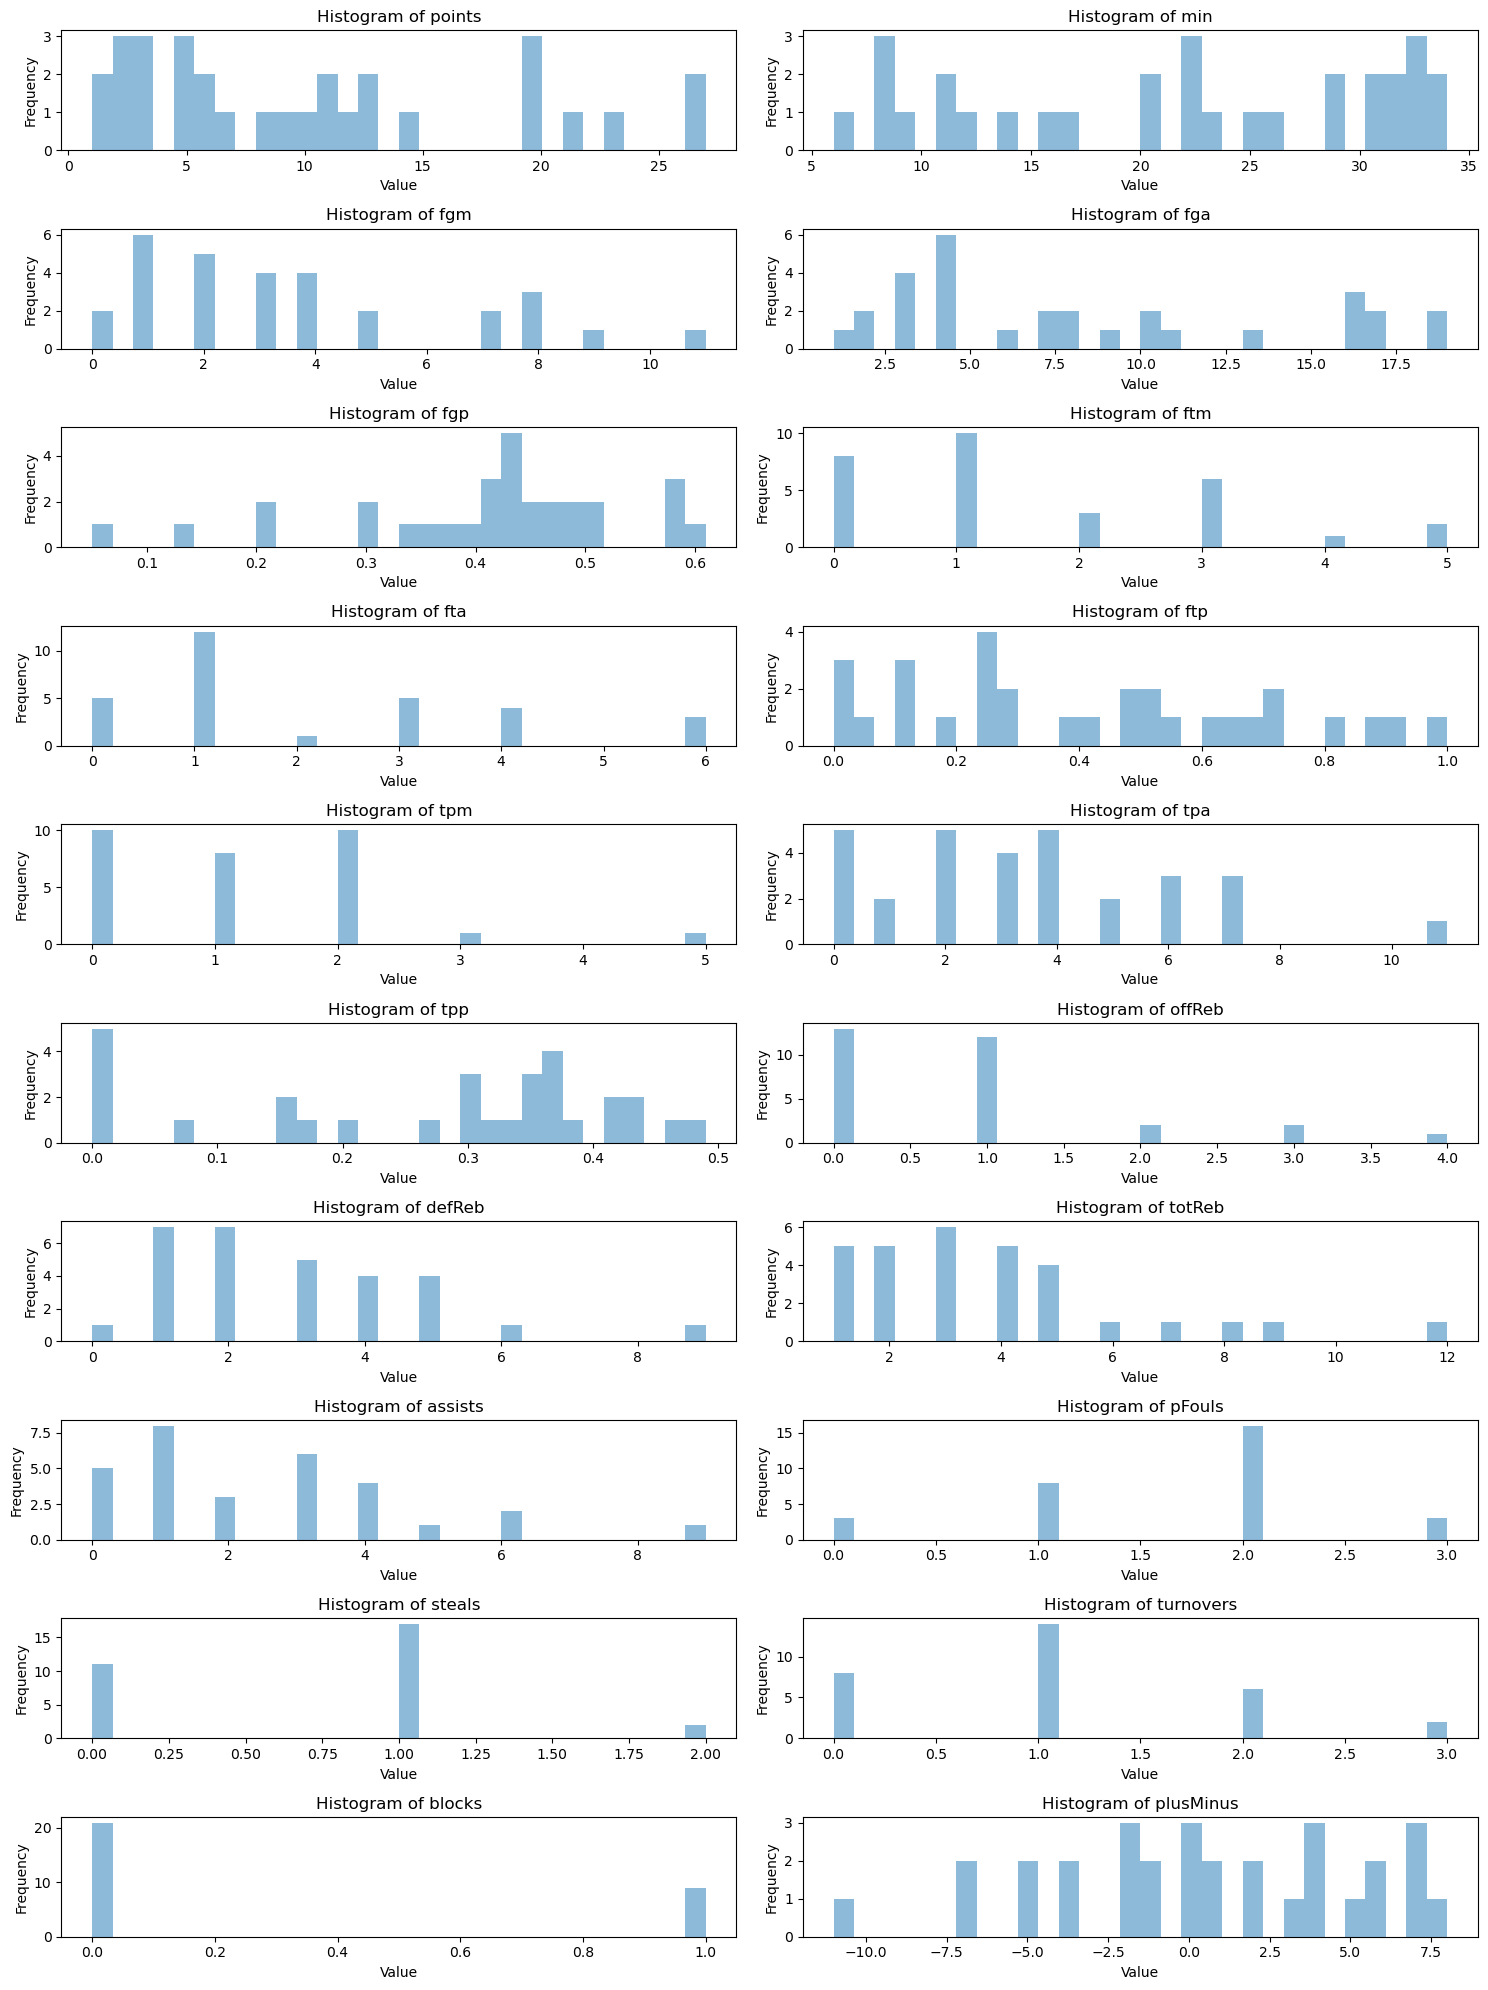

In [116]:
# Distribution of each Variable

selected_columns = ['points', 'min', 'fgm', 'fga', 'fgp', 'ftm', 'fta', 'ftp', 'tpm', 'tpa', 'tpp', 'offReb', 'defReb', 'totReb', 'assists', 'pFouls', 'steals', 'turnovers', 'blocks', 'plusMinus']

# Creating subplots
fig, axes = plt.subplots(nrows=len(selected_columns)//2, ncols=2, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5)

# Plotting histograms for each selected column in separate subplots
for col, ax in zip(selected_columns, axes.flatten()):
    ax.hist(stats[col], bins=30, alpha=0.5)
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.show()

In [ ]:
# Create all relevant barplots

In [ ]:
# Heigth Histogram
sns.histplot(players_df['height_m'])

# Optional: Customize plot labels and title
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Histogram of Height in Meters')

# Show the plot
plt.show()

In [ ]:
# Weight Histogram

# Heigth Histogram
sns.histplot(players_df['weight_kg'])

# Optional: Customize plot labels and title
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Histogram of Weight in Kilograms')

# Show the plot
plt.show()

In [ ]:
# Age boxplot
sns.histplot(x=players_df['age'], color='skyblue')

# Optional: Customize plot labels and title
plt.xlabel('Age')
plt.title('Age Distribution')

# Show the plot
plt.show()